In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from stellargraph.layer import GCN_LSTM

import datetime
import random
random.seed(10)

2022-05-17 14:07:03.992325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 14:07:03.992445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-17 14:07:46.717324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 14:07:46.718028: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 14:07:46.718195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-05-17 14:07:46.722636: I tensorflow/core/platform/cpu_fe

In [2]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [3]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [4]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]


    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    # TODO: Add buffer and consider train-data for range
    lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    long_range = {'min': df.long.min(), 'max': df.long.max()}

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [5]:
def train_test_split(df, grid_points_indices, train_size):
#     random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [6]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [7]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [8]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
#     mask = tf.sign(y_true)
#     y_pred = y_pred*(mask)
    loss = mse(y_pred[y_true>0], y_true[y_true>0] )
#     loss = mse(tf.reshape(y_true,(-1,)),tf.reshape(y_pred,(-1,)))
#     print(loss)
    return loss

In [9]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

In [10]:
def train_model(model, n_epochs, n_batch_size, trainX, trainY, testX, testY, train_data, save_path = None):
    cb = TimingCallback()
    net = model
    history = net.fit(
            trainX,
            trainY,
            epochs = n_epochs,
            batch_size = n_batch_size,
            shuffle=True,
            verbose=0,
            validation_data=[testX, testY],
            callbacks=[cb]
        )

    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    
    print(
        "Mean Train loss: ",
        sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
        "\n Last Train loss: ",
        tf.sqrt(history.history["loss"][-1])*max_pm,
        "\n Mean Test loss:",
        sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
        "\n Last Test loss:",
        tf.sqrt(history.history["val_loss"][-1])*max_pm,
    #     "\nTrain time ", traintime,
        "\n Train time callbacks", sum(cb.logs)
        
    )
    fig = sg.utils.plot_history(history, return_figure=True)
    if save_path is not None:
        fig.savefig(save_path)

In [11]:
def eval_model(model, testX, testY):
    net = model
    output = net.predict(testX)
    # yhat = model.predict(testX)

    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    test_output = np.array((output * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_output = test_output*(mask_test)
    test_mse = my_loss(test_true, test_output)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [12]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

In [13]:
tf.random.set_seed(45)
gcn_lstm = GCN_LSTM(
        seq_len=seq_len,
        adj=adj,
        gc_layer_sizes=[4, 4],
        gc_activations=["relu", "relu"],
        lstm_layer_sizes=[4],
        lstm_activations=["tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
opt = tf.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=opt, loss=my_loss)
print(model.summary())

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 3)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 270, 3, 1)        0         
                                                                 
 reshape (Reshape)           (None, 270, 3)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73182     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73186     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

## Predicting on 

In [15]:
# df = data_preparation('PM Datasets/2020-12-01_all.csv')
# # train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)
# for i in range(2, 8):
#     datafile = 'PM Datasets/2020-12-'
#     datafile +=  str(0) + str(i) if i<10 else str(i)
#     datafile +=  '_all.csv'
#     df1 = data_preparation(datafile)
#     df = pd.concat([df,df1], axis=1)
#     df = df.fillna(0)
# test_date = '2020-12-0' + str(i) if i<10 else '2020-12-' + str(i)
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)
# print('Test on' + datafile + ' using past 6 days data with finetuning')
# train_model(model, 100, trainX, trainY, testX, testY, train_data, save_path = './Forecasting results/' + test_date + '_test.png')
# test_output, test_true = eval_model(model, testX, testY)
# plot_predictions(test_output, test_true, save_path = './Forecasting results/' + test_date + '_predictions.png')

In [14]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
for i in range(2, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

## Finding optimal batch size

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)


/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:11: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  # This is added back by InteractiveShellApp.init_path()


Mean Train loss:  tf.Tensor(50.4075, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(38.807083, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(43.035213, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(33.123333, shape=(), dtype=float32) 
 Train time callbacks 12.33700699999872
1/1 [==============================] - 0s 384ms/step
Test RMSE:  tf.Tensor(32.90940041622449, shape=(), dtype=float64)
Mean Train loss:  tf.Tensor(48.59912, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(37.183125, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(38.358353, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(35.47039, shape=(), dtype=float32) 
 Train time callbacks 9.73021880000124
1/1 [==============================] - 0s 376ms/step
Test RMSE:  tf.Tensor(35.39344797871735, shape=(), dtype=float64)
Mean Train loss:  tf.Tensor(49.107914, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(40.56989, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(45.684097, s

1/1 [==============================] - 0s 380ms/step
Test RMSE:  tf.Tensor(44.749159531382844, shape=(), dtype=float64)
Mean Train loss:  tf.Tensor(55.26958, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(40.883537, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(43.145634, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(35.589306, shape=(), dtype=float32) 
 Train time callbacks 5.625823899999887
1/1 [==============================] - 0s 396ms/step
Test RMSE:  tf.Tensor(35.58930426997805, shape=(), dtype=float64)
Mean Train loss:  tf.Tensor(56.68041, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(43.030506, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(44.20462, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(37.742046, shape=(), dtype=float32) 
 Train time callbacks 5.181153299999551
1/1 [==============================] - 0s 394ms/step
Test RMSE:  tf.Tensor(37.742047715554875, shape=(), dtype=float64)
Mean Train loss:  tf.Tensor(56.719757, shape=(

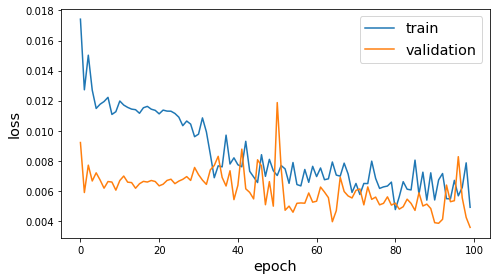

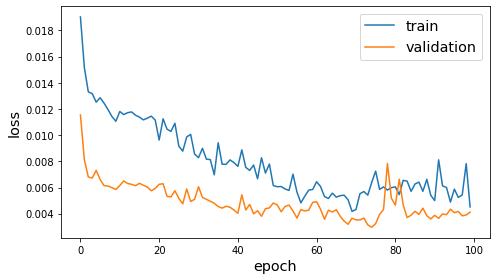

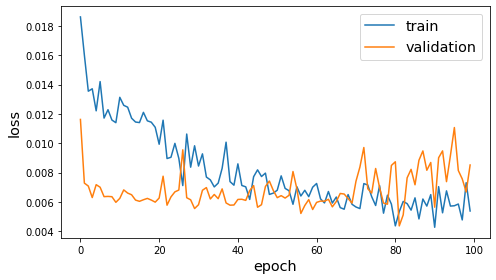

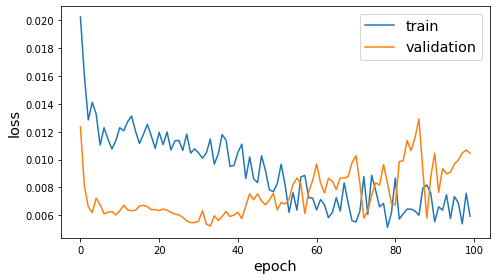

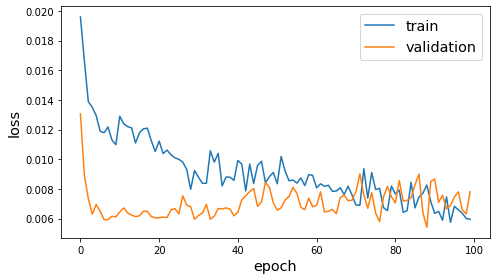

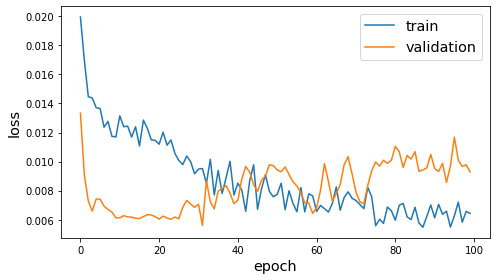

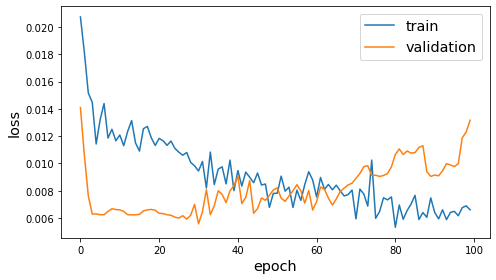

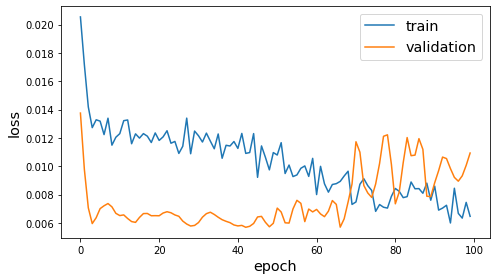

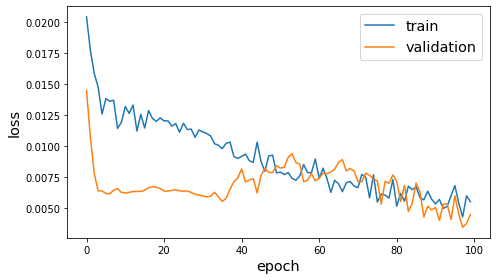

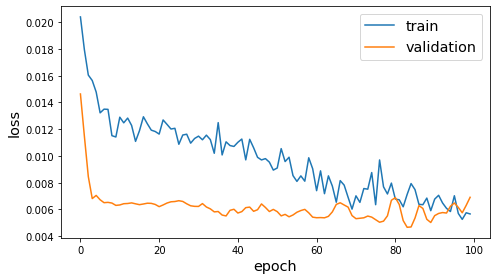

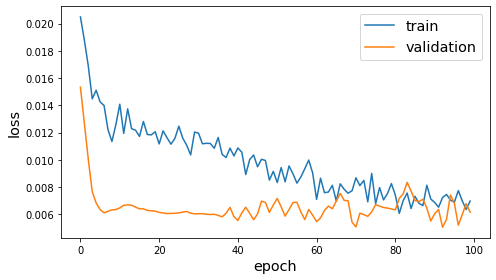

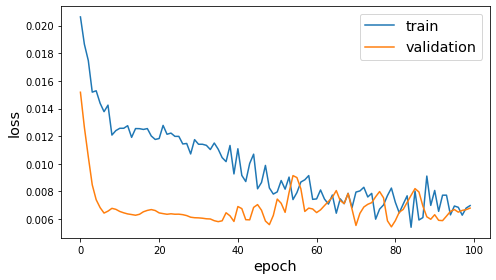

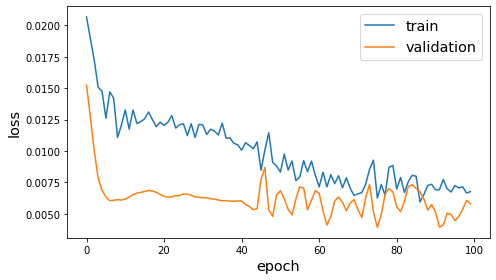

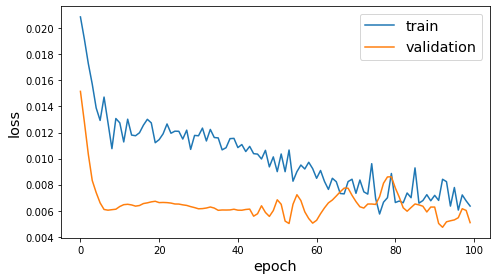

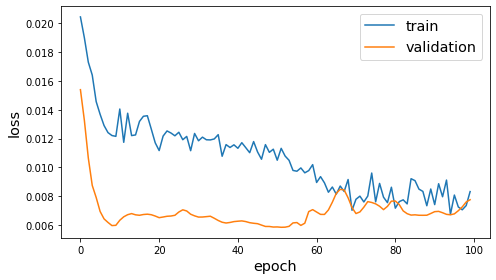

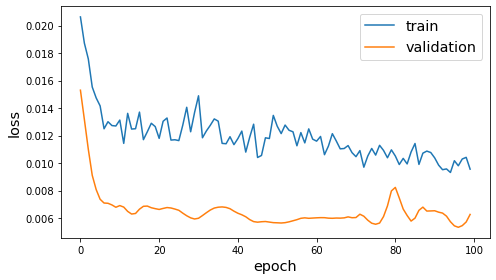

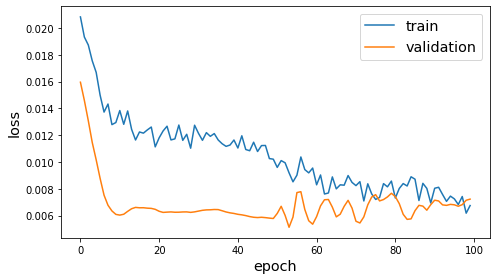

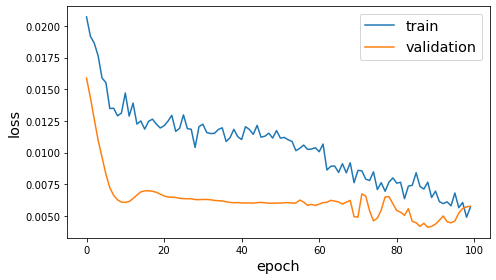

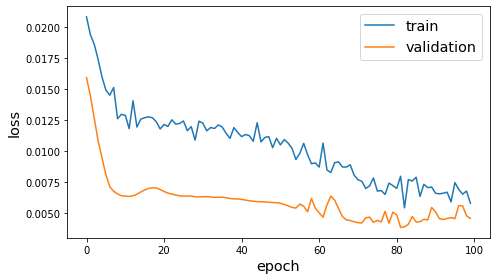

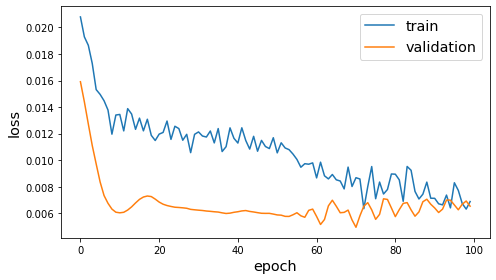

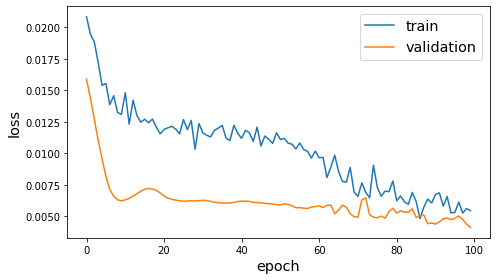

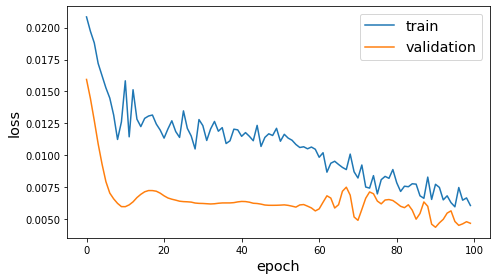

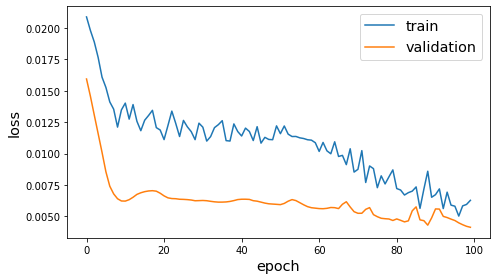

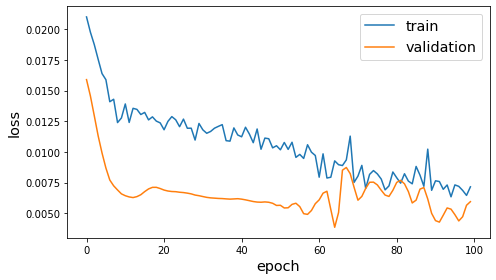

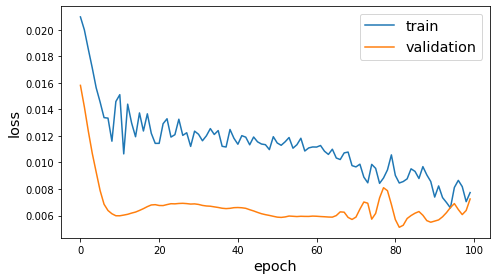

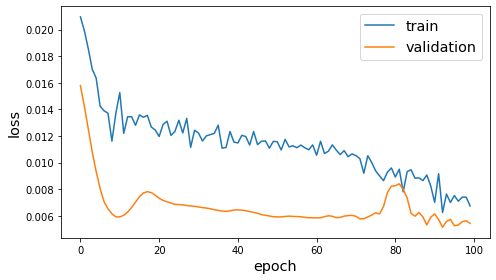

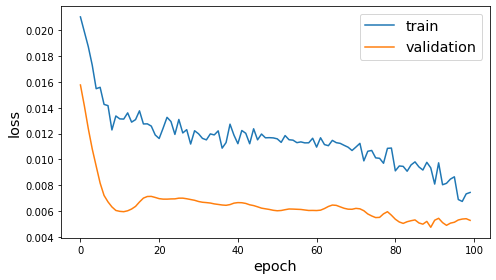

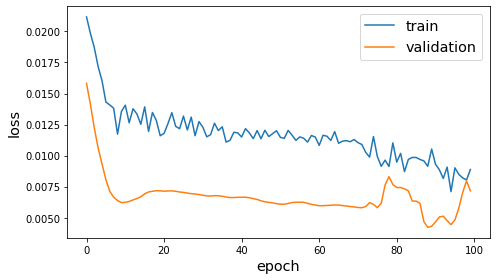

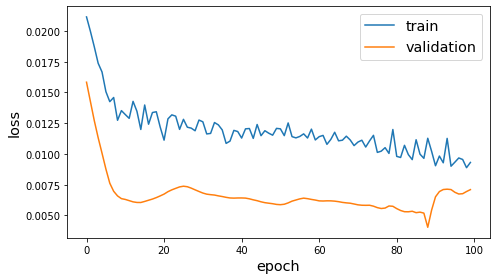

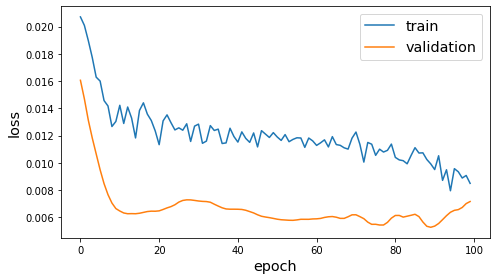

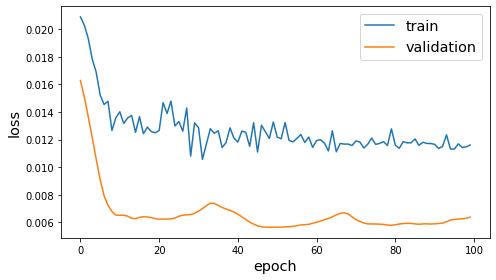

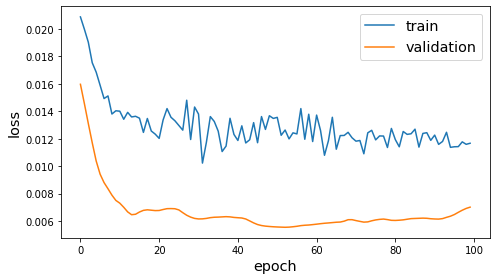

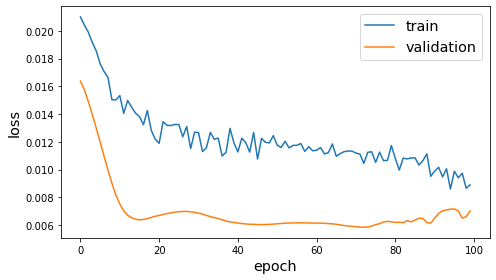

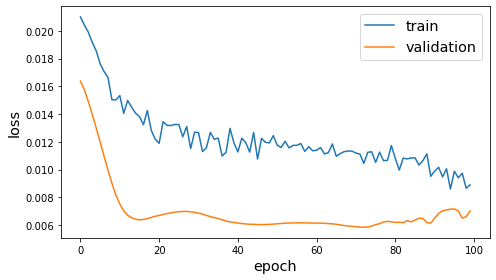

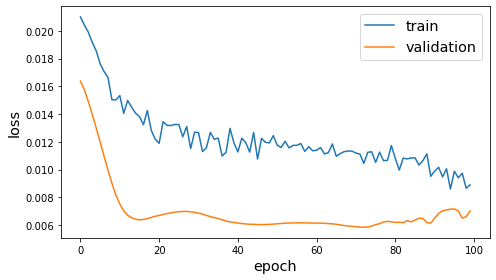

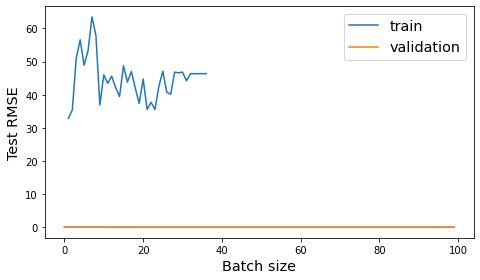

In [31]:
y = []
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)
for i in range(1, 37):
    tf.random.set_seed(45)
    gcn_lstm = GCN_LSTM(
            seq_len=seq_len,
            adj=adj,
            gc_layer_sizes=[4, 4],
            gc_activations=["relu", "relu"],
            lstm_layer_sizes=[4],
            lstm_activations=["tanh"],
        )
    x_input, x_output = gcn_lstm.in_out_tensors()
    model = Model(inputs = x_input, outputs = x_output)
    opt = tf.optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = opt, loss = my_loss)
    
    train_model(model, 100, i, trainX, trainY, testX, testY, train_data)
    test_rmse = eval_model(model, testX, testY)
    y.append(test_rmse)

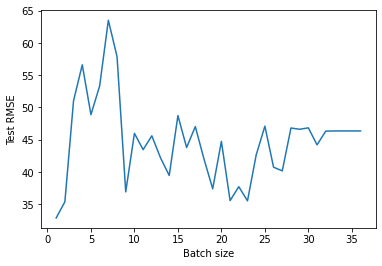

In [38]:
x = [i for i in range(1, 37)]
plt.plot(x, y)
plt.xlabel("Batch size")
plt.ylabel("Test RMSE")
plt.show()
np.argsort(y)
y[22]

## Training and testing on week1

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)
Mean Train loss:  tf.Tensor(56.719757, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(43.82855, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(43.209053, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(35.549683, shape=(), dtype=float32) 
 Train time callbacks 17.106011400000114
1/1 [==============================] - 2s 2s/step
Test RMSE:  tf.Tensor(35.549682482230175, shape=(), dtype=float64)


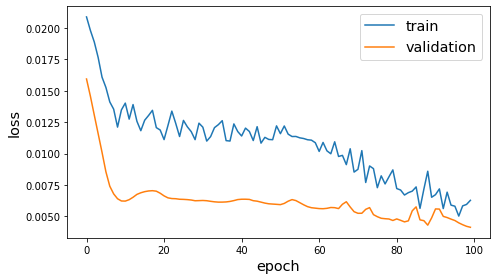

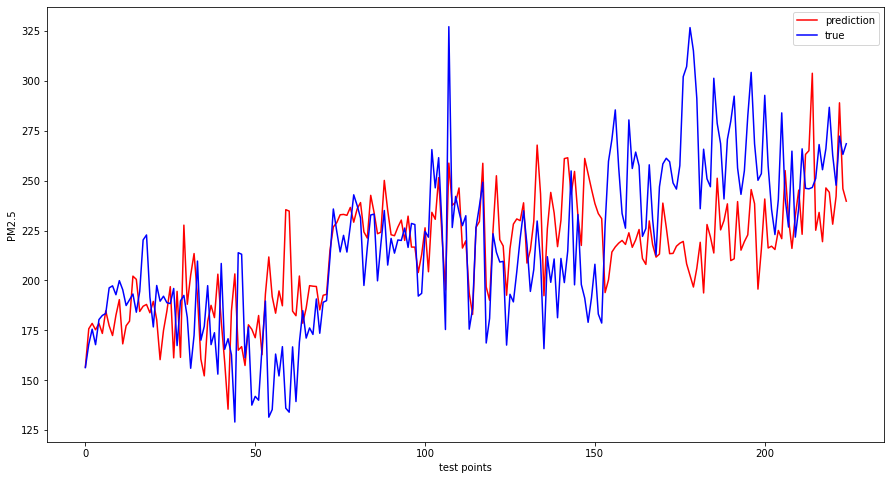

In [15]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)
train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)

## Test on next 3-hrs with previous weights

In [64]:
df_temp = data_preparation('PM Datasets/2020-12-08_all.csv')
df2 = pd.concat([df,df_temp], axis=1).iloc[:, 1:-5]
df2 = df2.fillna(0)

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)
1/1 [==============================] - 0s 19ms/step
Test RMSE:  tf.Tensor(51.74870562813254, shape=(), dtype=float64)


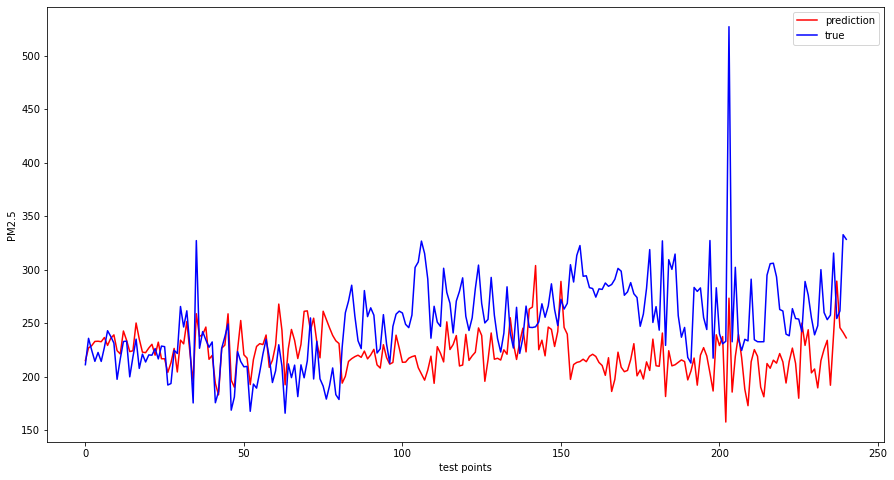

In [65]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df2, grid_points_indices, train_size = 0.86)
# train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)

## Training on next-3 hrs with previous weights and lr =0.01

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)
Mean Train loss:  tf.Tensor(41.653965, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(42.18768, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(40.001984, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(42.78233, shape=(), dtype=float32) 
 Train time callbacks 2.971009499997308
1/1 [==============================] - 0s 18ms/step
Test RMSE:  tf.Tensor(42.782330260870786, shape=(), dtype=float64)


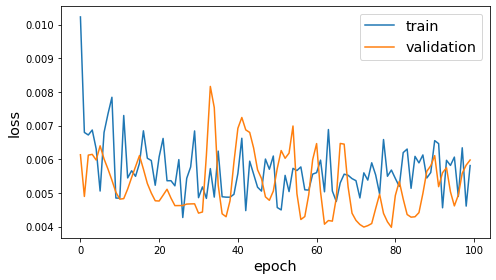

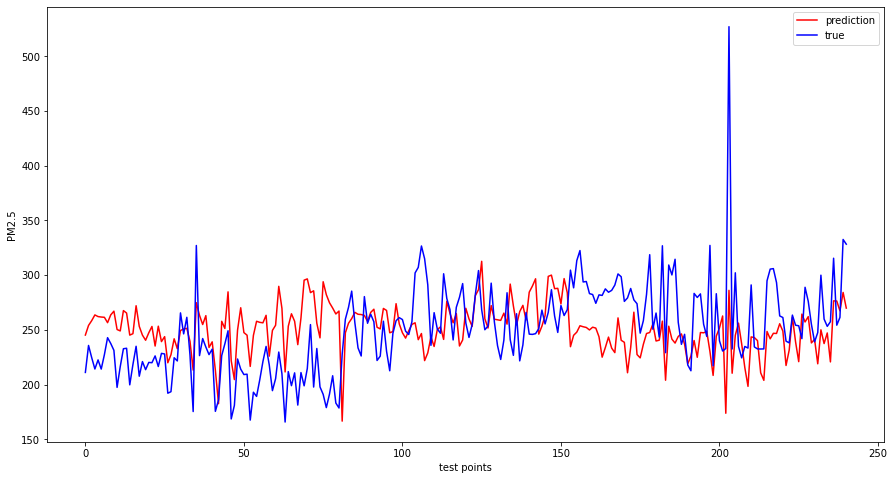

In [54]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df2, grid_points_indices, train_size = 0.86)
train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)

## Training on next 3-hr with previous weights and lr =0.001

In [66]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=opt, loss=my_loss)

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)
Mean Train loss:  tf.Tensor(42.48793, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(39.00992, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(39.269108, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(37.78799, shape=(), dtype=float32) 
 Train time callbacks 5.382345400003942
1/1 [==============================] - 0s 387ms/step
Test RMSE:  tf.Tensor(37.78798797954083, shape=(), dtype=float64)


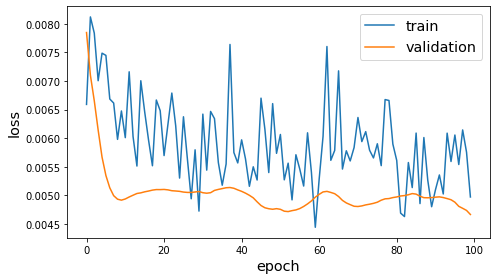

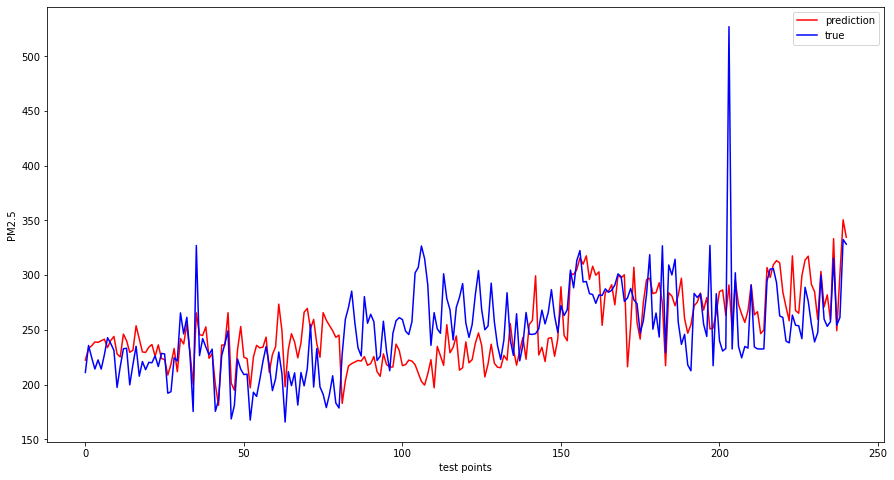

In [67]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df2, grid_points_indices, train_size = 0.86)
train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)

## Eval on next 3-hr with previous weights

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)
1/1 [==============================] - 0s 19ms/step
Test RMSE:  tf.Tensor(36.18394519770842, shape=(), dtype=float64)


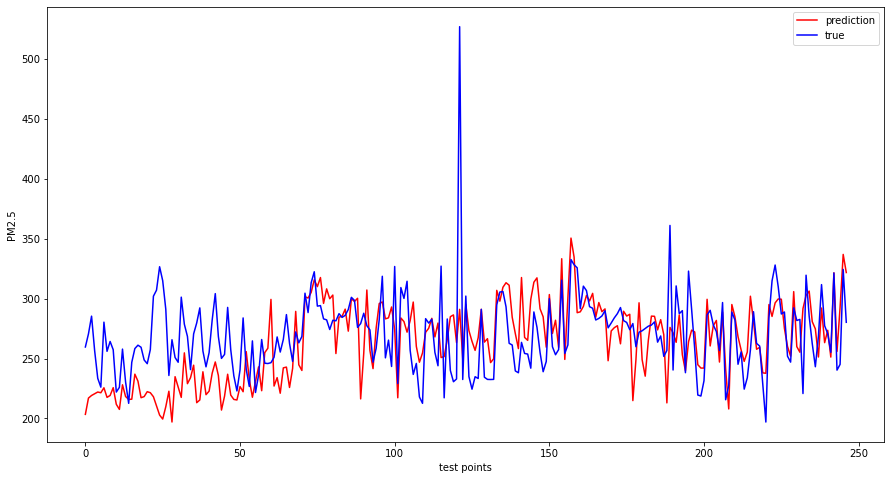

In [69]:
df2 = pd.concat([df,df_temp], axis=1).iloc[:, 2:-4]
df2 = df2.fillna(0)
trainX, trainY, testX, testY, train_data = prepare_train_data(df2, grid_points_indices, train_size = 0.86)
# train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)

## Training on next 3-hr with previous weights and lr =0.001

Mean Train loss:  tf.Tensor(40.311905, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(41.771065, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(38.490704, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(38.844276, shape=(), dtype=float32) 
 Train time callbacks 5.332412899991141
1/1 [==============================] - 0s 379ms/step
Test RMSE:  tf.Tensor(38.8442747941792, shape=(), dtype=float64)


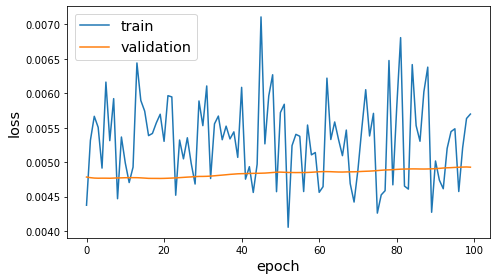

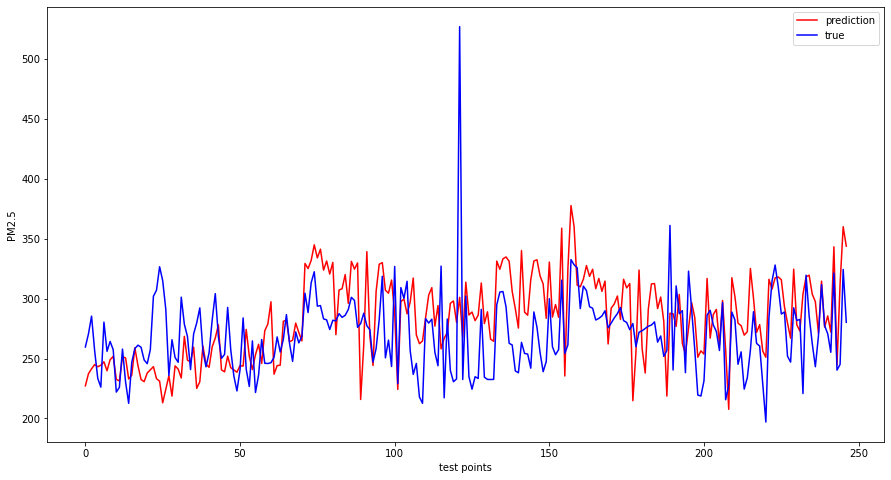

In [72]:
# df2 = pd.concat([df,df_temp], axis=1).iloc[:, 2:-4]
# df2 = df2.fillna(0)
# trainX, trainY, testX, testY, train_data = prepare_train_data(df2, grid_points_indices, train_size = 0.86)
opt = tf.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=opt, loss=my_loss)
train_model(model, 100, 23, trainX, trainY, testX, testY, train_data)
test_output, test_true = eval_model(model, testX, testY)
plot_predictions(test_output, test_true)